In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
import components.data_utils as data_utils
import numpy as np
import plots
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from components.vae import VAE_base
from utils import set_seed, get_vae_embedding, run_kmean, load_cbm_pipline
from components.data_utils import get_classes
from captum.attr import IntegratedGradients
from lfxai.explanations.features import attribute_auxiliary

set_seed(seed=42)
device = torch.device("cuda:1")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def get_concepts(concept_load_path):
    with open(os.path.join(concept_load_path, "concepts.txt"), "r") as f:
        concepts = f.read().split("\n")
    return concepts

def load_vae(vae_load_path, input_dim, hidden_dim, latent_dim):
    vae = VAE_base(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, dropout=False, batch_norm=True)
    vae.load_state_dict(torch.load(vae_load_path))
    vae.eval()
    return vae

def get_data(concept_load_path, dataset, target_preprocess):
    val_d_probe = dataset+"_val"
    val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
    val_pil_data = data_utils.get_data(val_d_probe)

    classes = data_utils.get_classes(dataset)
    concepts = get_concepts(concept_load_path)
    return val_data_t, val_pil_data, classes, concepts

def eval_image(display_list, model, vae, val_data_t, val_pil_data, classes, concepts):
    attr_method = IntegratedGradients(vae)
    baseline = torch.zeros((1, len(concepts)))

    with torch.no_grad():
        for i in display_list:
            image, label = val_pil_data[i]
            x, l = val_data_t[i]
            x = x.unsqueeze(0).to(device)
            display(image.resize([320,320]))
            
            concept_act = model(x)
            concept_act = concept_act.double()
        
            test_loader = DataLoader(TensorDataset(concept_act, concept_act), batch_size=1, shuffle=False)
            
            feature_importance = attribute_auxiliary(vae.encoder.to(torch.device('cpu')), test_loader,
                                            'cpu', attr_method, baseline)
            

            print("Image:{} Gt:{}".format(i, classes[int(label)]))
            
            contributions = concept_act[0]* torch.from_numpy(feature_importance).squeeze().to(device)
            #contributions = concept_act[0]*model.final.weight[top_classes[0], :]
        
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred"
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)


## 1. CIFAR10-ViT-L/14

In [9]:
# Please modify the following.
dataset = 'cifar10'
vae_epoch = 425
latent_dim = 128
hidden_dim = latent_dim*2
base_load_path = '../saved_models_gpt4/cifar10/base-vit-l14'
concept_load_path = f'{base_load_path}/cbm_clip_ViT-L/14/'
vae_load_path = f'{base_load_path}/vae/both_z{latent_dim}_bn_e{vae_epoch}.pth'
seed=42

len(get_classes(dataset))

10

In [10]:
cbm_pipeline, target_preprocess = load_cbm_pipline(concept_load_path, device)
val_data_t, val_pil_data, classes, concepts = get_data(concept_load_path, dataset, target_preprocess)
vae = load_vae(vae_load_path, len(concepts), hidden_dim, latent_dim).double().to(device)

Files already downloaded and verified
Files already downloaded and verified


### Concept mining

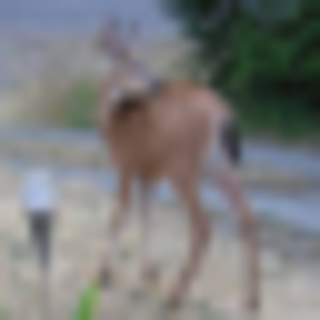

Image:100 Gt:deer


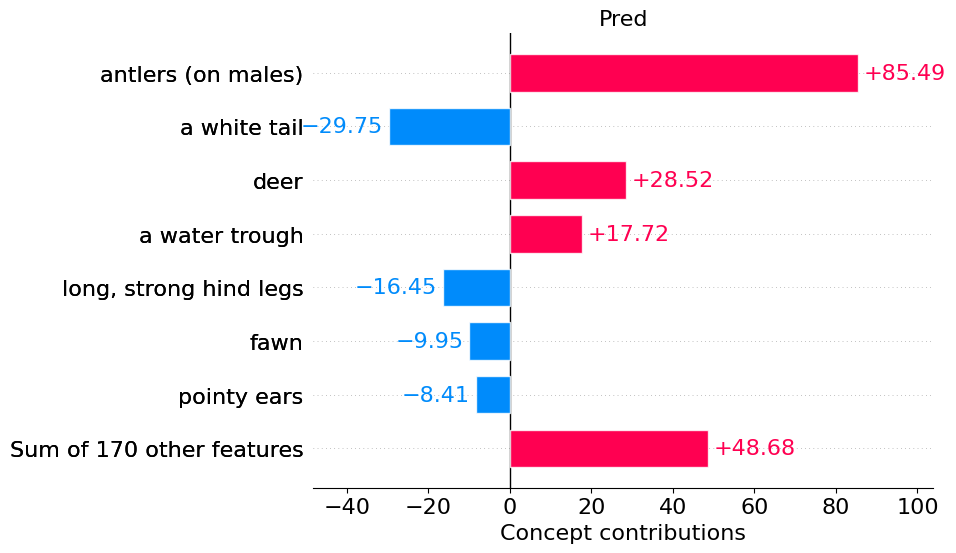

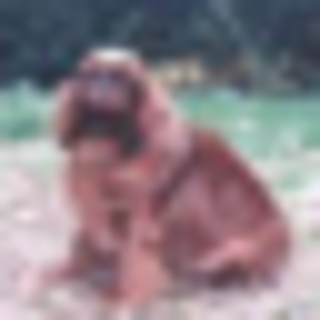

Image:101 Gt:dog


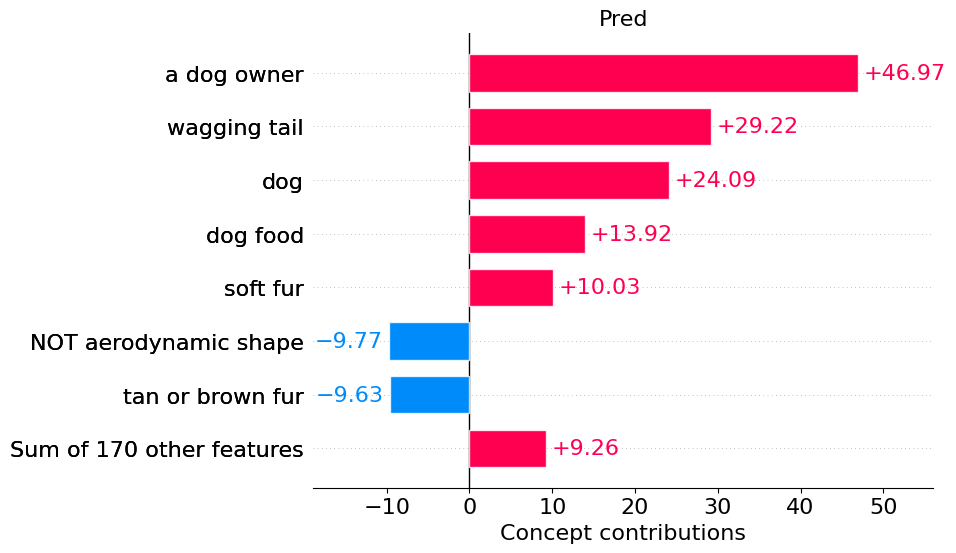

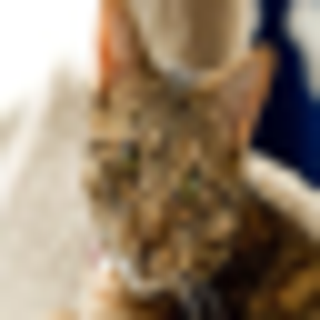

Image:103 Gt:cat


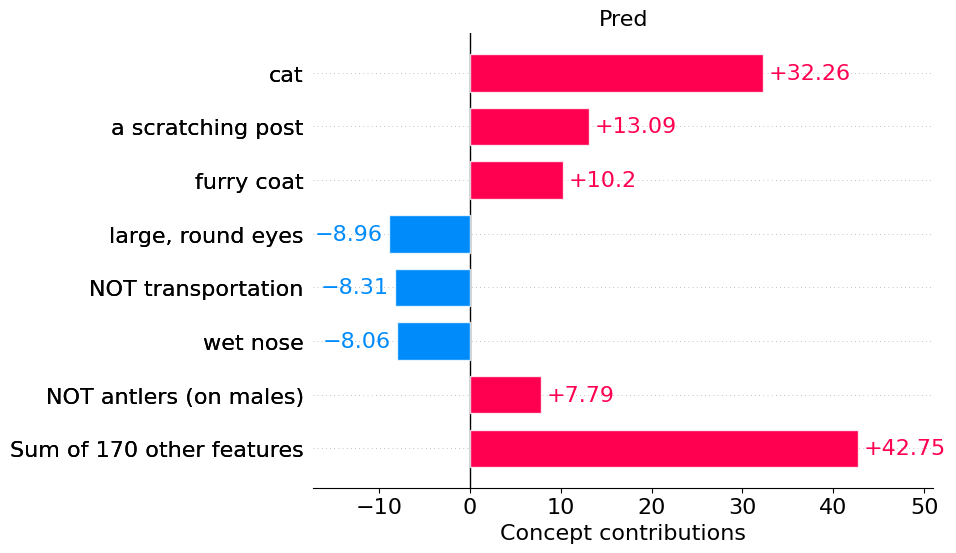

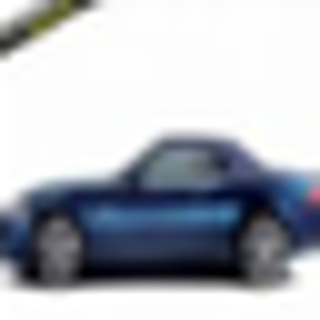

Image:105 Gt:automobile


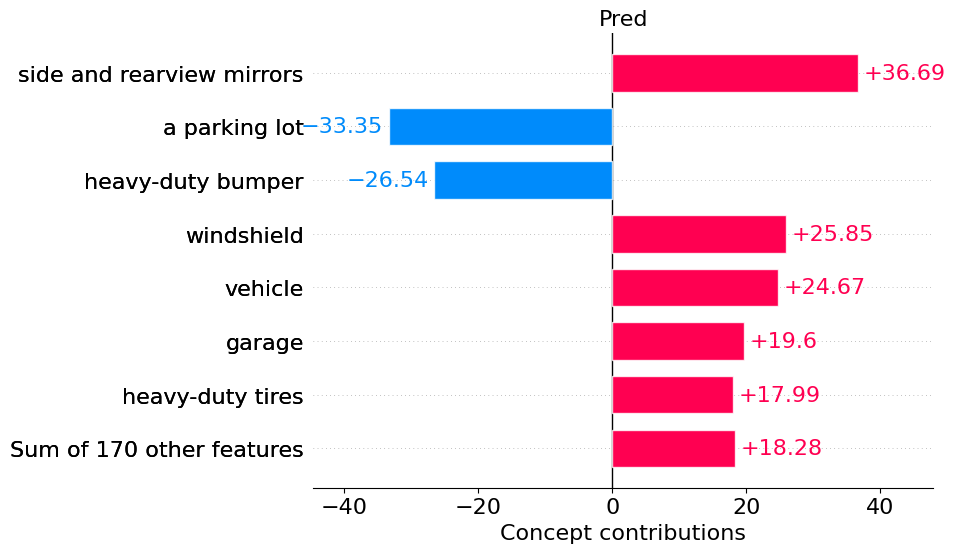

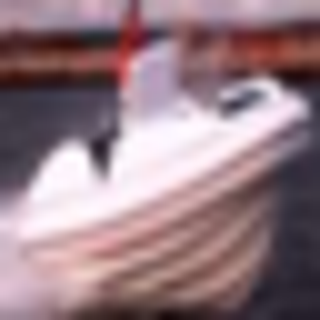

Image:108 Gt:ship


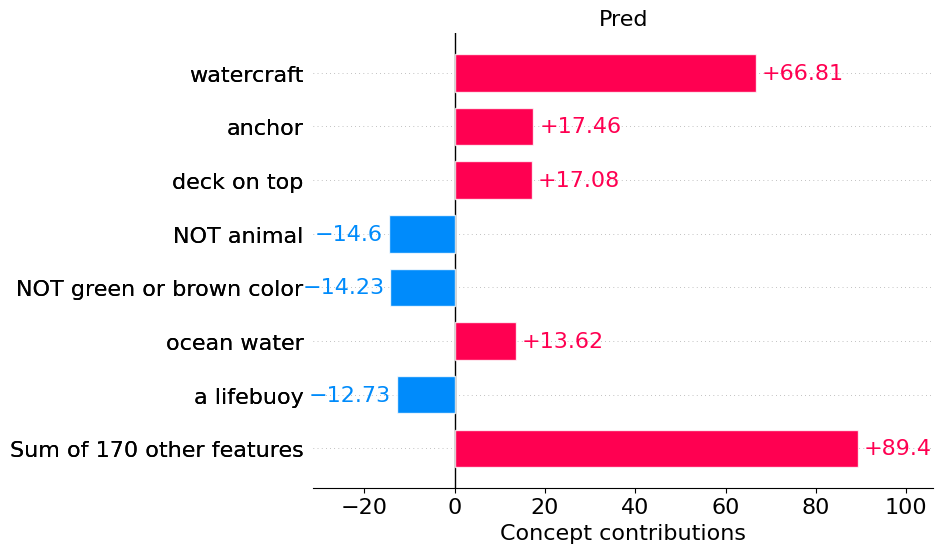

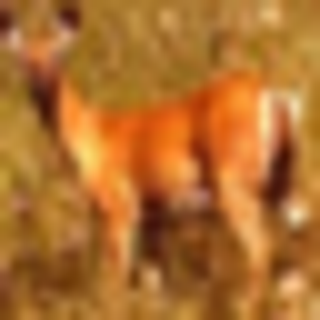

Image:110 Gt:deer


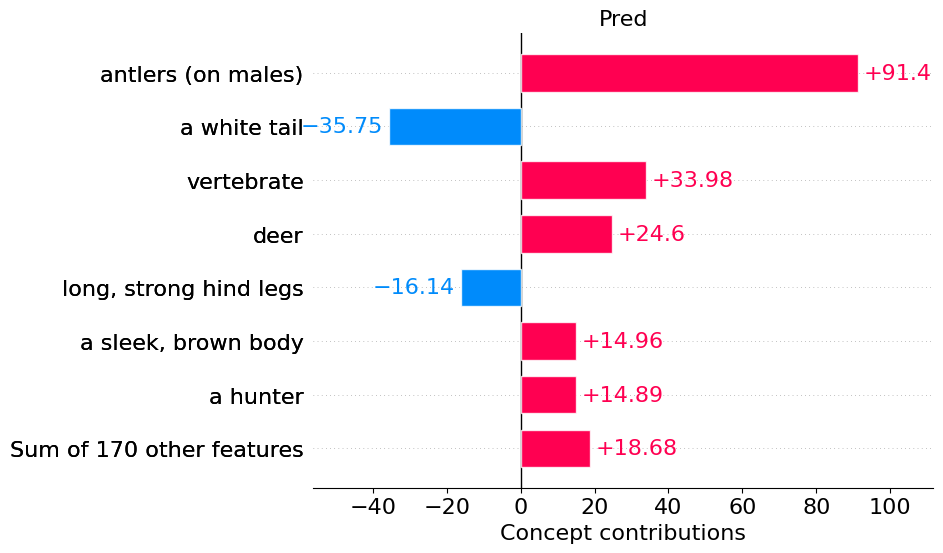

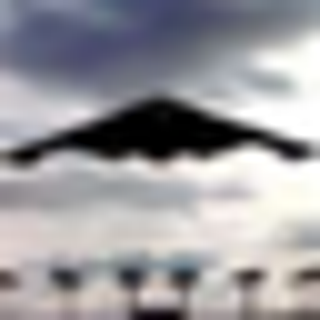

Image:111 Gt:airplane


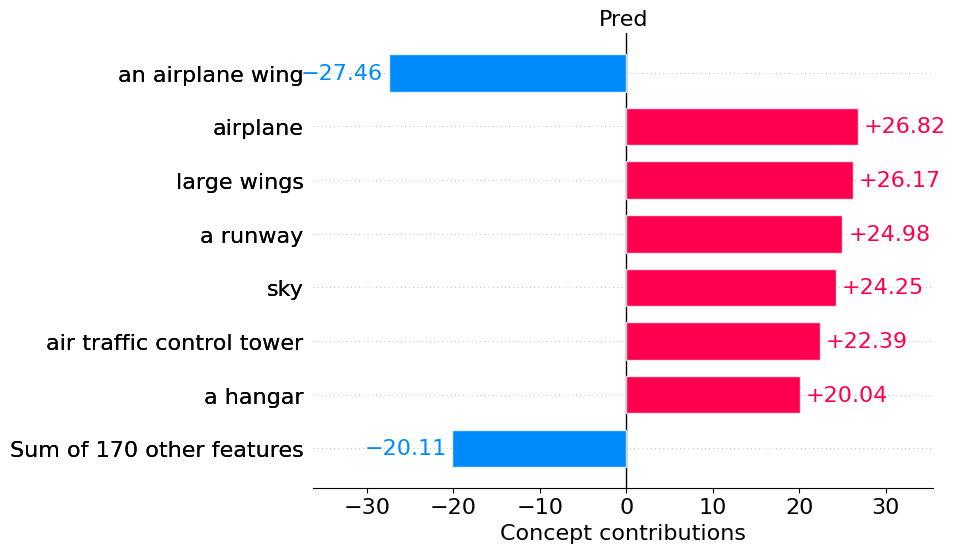

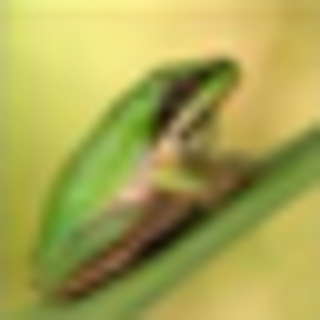

Image:112 Gt:frog


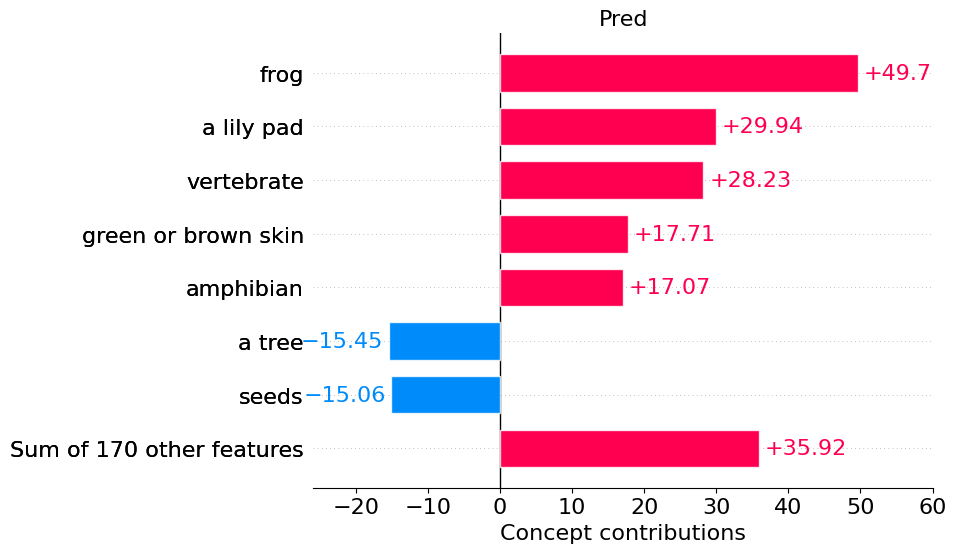

In [11]:
img_idx = [100, 101, 103, 105, 108, 110, 111, 112]
eval_image(img_idx, cbm_pipeline, vae, val_data_t, val_pil_data, classes, concepts)


## 2. CIFAR100-20-RN50

In [14]:
# Please modify the following.
dataset = 'cifar100-20'
vae_epoch = 250
latent_dim = 128
hidden_dim = latent_dim*2
base_load_path = f'../saved_models_gpt4/{dataset}/base-rn50'
concept_load_path = f'{base_load_path}/cbm_clip_RN50/'
vae_load_path = f'{base_load_path}/vae/both_z{latent_dim}_bn_e{vae_epoch}.pth'
seed=42

len(get_classes(dataset))

20

In [15]:
cbm_pipline, target_preprocess = load_cbm_pipline(concept_load_path, device)
val_data_t, val_pil_data, classes, concepts = get_data(concept_load_path, dataset, target_preprocess)
vae = load_vae(vae_load_path, len(concepts), hidden_dim, latent_dim).double().to(device)

Files already downloaded and verified
Files already downloaded and verified


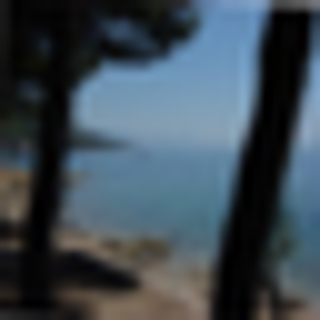

Image:10 Gt:large natural outdoor scenes


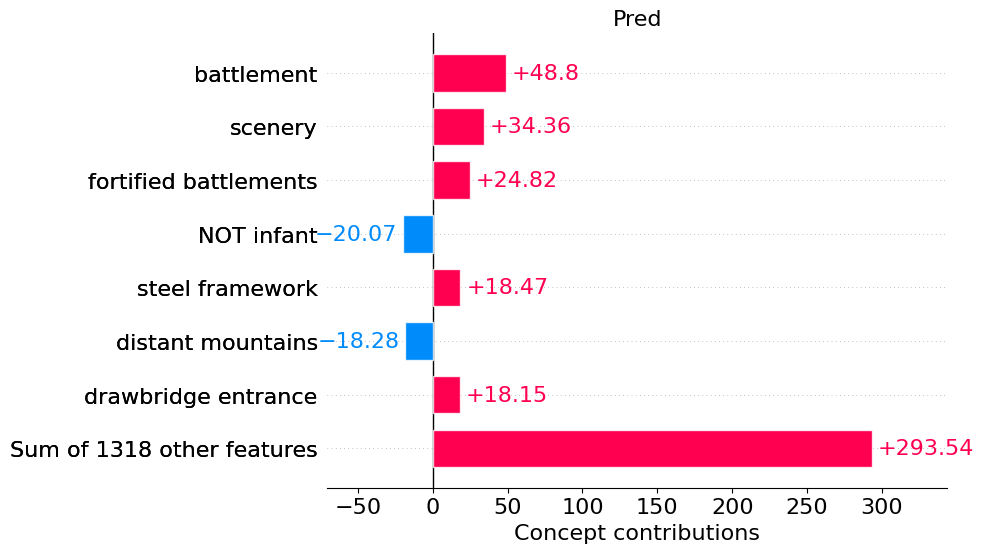

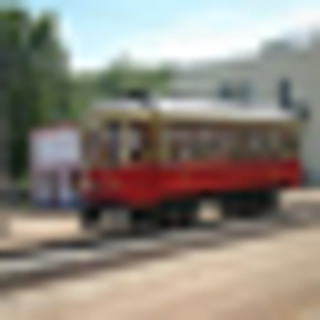

Image:12 Gt:vehicles 2


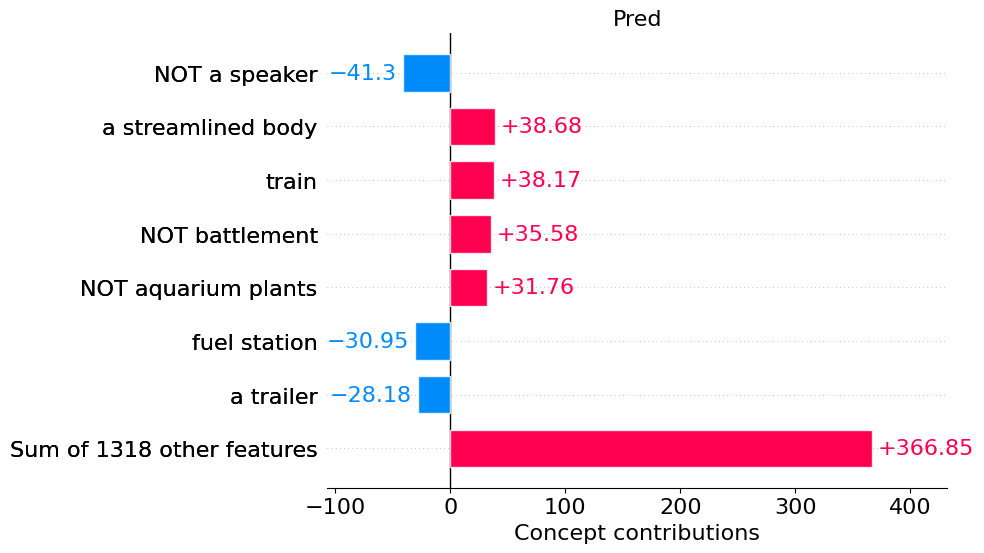

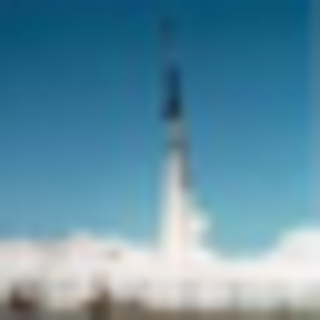

Image:13 Gt:vehicles 2


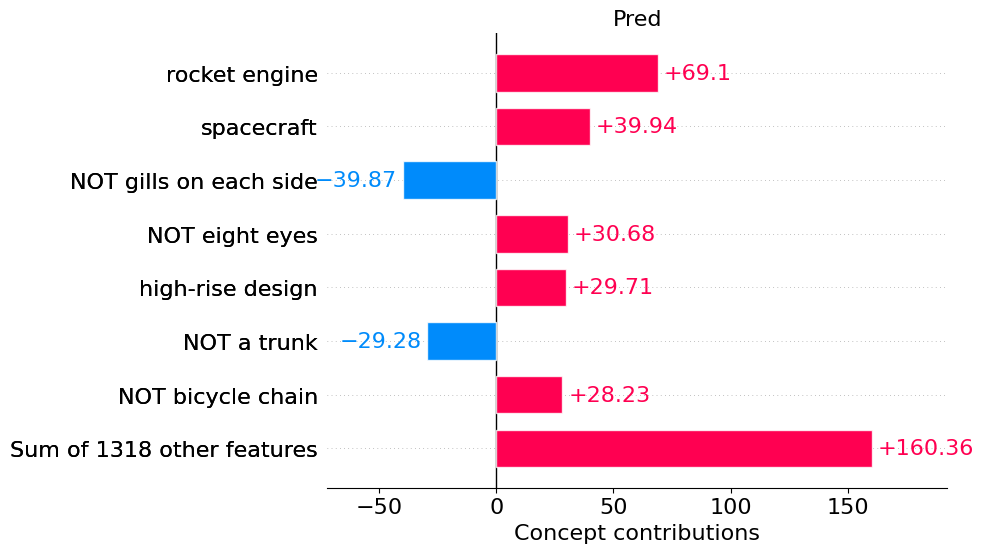

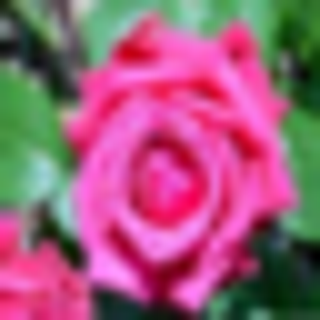

Image:18 Gt:flowers


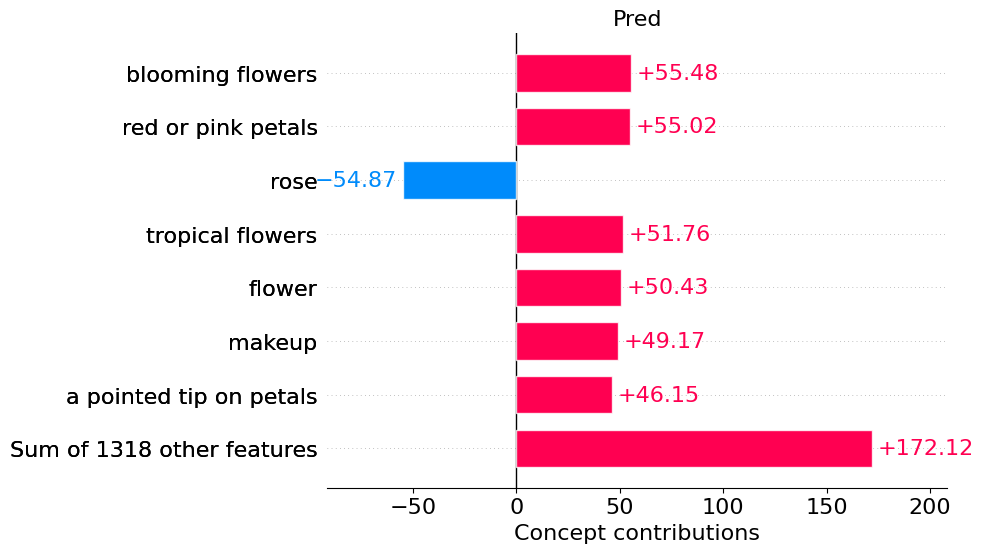

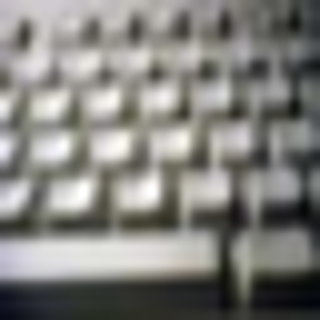

Image:26 Gt:household electrical devices


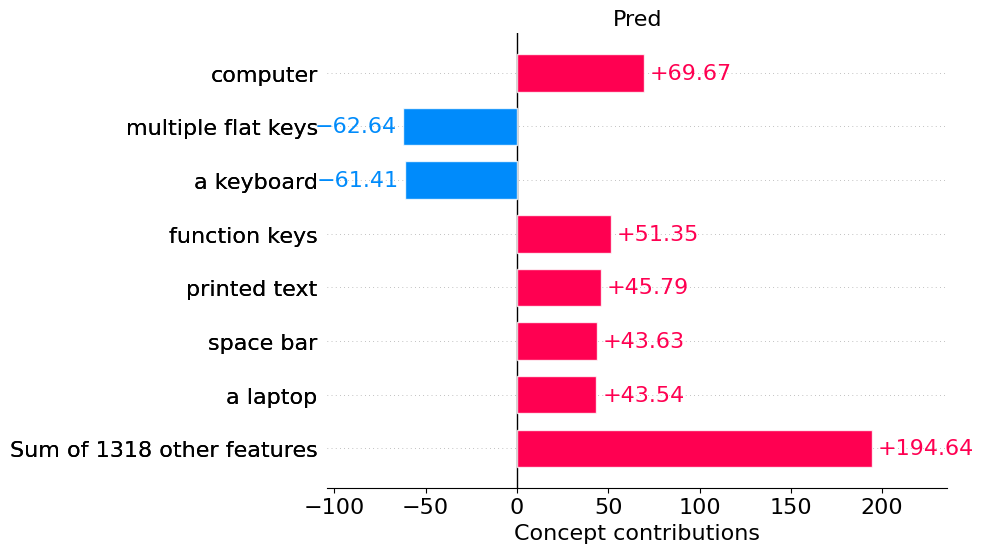

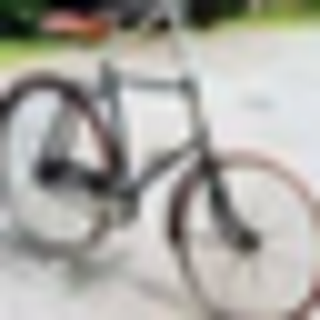

Image:27 Gt:vehicles 1


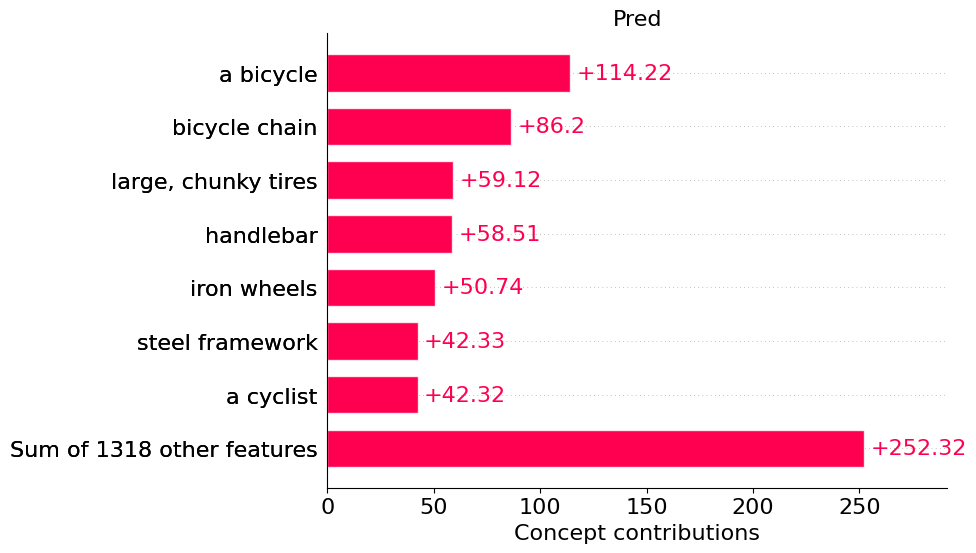

In [16]:
eval_image([10, 12, 13, 18, 26, 27], cbm_pipline, vae, val_data_t, val_pil_data, classes, concepts)